In [1]:
import pickle
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

import xgboost as xgb   

from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll.base import scope

import mlflow

In [2]:
MLFLOW_TRACKING_URI = "sqlite:///mlflow.db"

mlflow.set_tracking_uri(MLFLOW_TRACKING_URI)
mlflow.set_experiment("duration_prediction")

2023/04/22 23:50:55 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2023/04/22 23:50:55 INFO mlflow.store.db.utils: Updating database tables
INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.runtime.migration] Will assume non-transactional DDL.
INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.runtime.migration] Will assume non-transactional DDL.


<Experiment: artifact_location='/home/hilbert/mlflow/duration_prediction/mlruns/1', creation_time=1681756184652, experiment_id='1', last_update_time=1681756184652, lifecycle_stage='active', name='duration_prediction', tags={}>

# preparacion de datos

In [3]:
dftr = pd.read_parquet("data/yellow_tripdata_2022-01.parquet")
dfts = pd.read_parquet("data/yellow_tripdata_2023-01.parquet")
dftr.head(3)

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
0,1,2022-01-01 00:35:40,2022-01-01 00:53:29,2.0,3.80,1.0,N,142,236,1,14.5,3.0,0.5,3.65,0.0,0.3,21.95,2.5,0.0
1,1,2022-01-01 00:33:43,2022-01-01 00:42:07,1.0,2.10,1.0,N,236,42,1,8.0,0.5,0.5,4.00,0.0,0.3,13.30,0.0,0.0
2,2,2022-01-01 00:53:21,2022-01-01 01:02:19,1.0,0.97,1.0,N,166,166,1,7.5,0.5,0.5,1.76,0.0,0.3,10.56,0.0,0.0


In [4]:
dftr["duration"] = dftr.tpep_dropoff_datetime - dftr.tpep_pickup_datetime
dfts["duration"] = dfts.tpep_dropoff_datetime - dfts.tpep_pickup_datetime

dftr["duration"] = dftr.duration.dt.total_seconds()
dfts["duration"] = dfts.duration.dt.total_seconds()

dftr = dftr[dftr["duration"] < 60*60*12].reset_index(drop=True)
dfts = dfts[dfts["duration"] < 60*60*12].reset_index(drop=True)

dftr = dftr[dftr["duration"] > 0].reset_index(drop=True)
dfts = dfts[dfts["duration"] > 0].reset_index(drop=True)

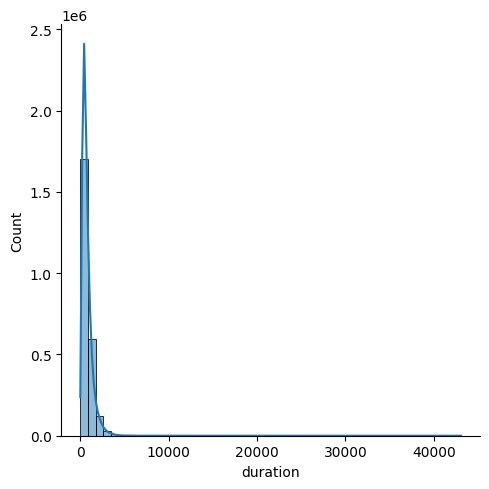

In [5]:
sns.displot(dftr.duration, kde=True, bins=50)

In [6]:
dftr.duration.describe(percentiles=[0.95, 0.98, 0.99])

count    2.458976e+06
mean     7.689927e+02
std      6.538940e+02
min      1.000000e+00
50%      6.110000e+02
95%      1.904000e+03
98%      2.496000e+03
99%      2.974000e+03
max      4.306400e+04
Name: duration, dtype: float64

In [5]:
categoricals = ["PULocationID", "DOLocationID"]
numericals = ["trip_distance"]

dftr[categoricals] = dftr[categoricals].astype(str)
dfts[categoricals] = dfts[categoricals].astype(str)

In [6]:
train_dict = dftr[categoricals + numericals].to_dict(orient="records")
test_dict = dfts[categoricals + numericals].to_dict(orient="records")
dicts = train_dict + test_dict

dv = DictVectorizer()
dv.fit(dicts)

xtr = dv.transform(train_dict)
xts = dv.transform(test_dict)

ytr, yts = dftr.duration, dfts.duration

# ajustar y registrarse

620.7482521199078


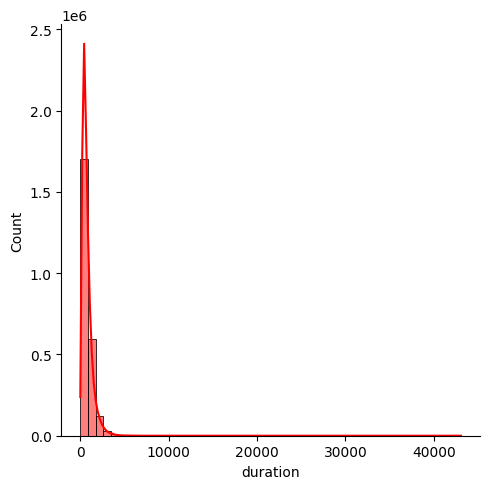

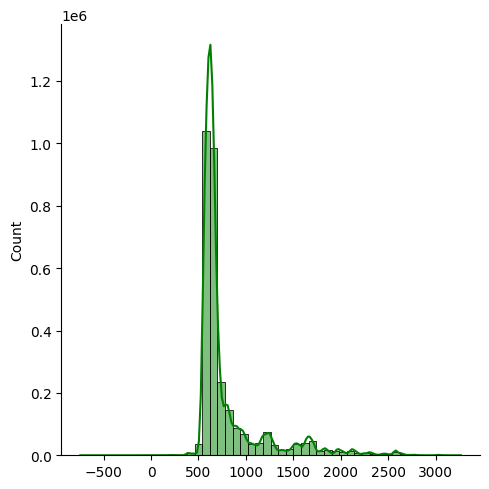

In [9]:
with mlflow.start_run():

    mlflow.set_tag("model", "linear_regression")

    mlflow.log_param("train_size", len(dftr))
    mlflow.log_param("test_size", len(dfts))

    fit_interceptbool = True

    mlflow.log_param("fit_interceptbool", fit_interceptbool)

    lr = LinearRegression(fit_intercept=fit_interceptbool)
    lr.fit(xtr, ytr)
    ypr = lr.predict(xts)

    print(mean_squared_error(yts, ypr, squared=False))

    mlflow.log_metric("rmse", mean_squared_error(yts, ypr, squared=False))

    sns.displot(dftr.duration, kde=True, bins=50, color="red")
    sns.displot(ypr, kde=True, bins=50, color='green')
    plt.show()

In [12]:
xtr = dftr[categoricals + numericals].values
xts = dfts[categoricals + numericals].values
ytr, yts = dftr.duration.values, dfts.duration.values

xtr, xvl, ytr, yvl = train_test_split(xtr, ytr, test_size=0.2, random_state=42)
train = xgb.DMatrix(xtr, label=ytr)
valid = xgb.DMatrix(xvl, label=yvl)
test = xgb.DMatrix(xts, label=yts)

def objective(params):
    with mlflow.start_run():

        mlflow.set_tag("model", "xgboost")
        mlflow.log_params(params)
        booster = xgb.train(
            params=params,
            dtrain=train,
            num_boost_round=100,
            evals=[(valid, "valid")],
            early_stopping_rounds=10,
        )
        ypr = booster.predict(test)
        rmse = mean_squared_error(yts, ypr, squared=False)
        mlflow.log_metric("rmse", rmse)

        mlflow.xgboost.autolog()

        pickle.dump(booster, open("model.pkl", "wb"))
        if True:
            mlflow.log_artifact(local_path="model.pkl", artifact_path="models_pickle/model.pkl")
        if True:
            mlflow.xgboost.log_model(booster, artifact_path="models_mlflow")

    return {"loss": rmse, "status": STATUS_OK}

search_space = {
    "max_depth": scope.int(hp.quniform("max_depth", 3, 10, 1)),
    "learning_rate": hp.loguniform("learning_rate", -5, 0),
    "reg_alpha": hp.loguniform("reg_alpha", -5, 0),
    "reg_lambda": hp.loguniform("reg_lambda", -5, 0),
    "min_child_weight": hp.loguniform("min_child_weight", -5, 0),
    "objective": "reg:linear",
    "seed": 42,
}

best_result = fmin(
    fn=objective,
    space=search_space,
    algo=tpe.suggest,
    max_evals=50,
    trials=Trials()) 
    

[17:44:31] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	valid-rmse:952.29423                              
[1]	valid-rmse:900.09430                              
[2]	valid-rmse:852.24540                              
[3]	valid-rmse:808.43086                              
[4]	valid-rmse:768.45731                              
[5]	valid-rmse:732.02171                              
[6]	valid-rmse:698.88815                              
[7]	valid-rmse:668.84713                              
[8]	valid-rmse:641.65625                              
[9]	valid-rmse:617.07538                              
[10]	valid-rmse:594.92497                             
[11]	valid-rmse:575.07345                             
[12]	valid-rmse:557.23195                             
[13]	valid-rmse:541.30414                             
[14]	valid-rmse:527.05288                             
[15]	valid-rmse:514.42620                             
[

In [18]:
logged_model = 'runs:/52b850f2b380474fb98f80363e43d02d/model'
loaded_model = mlflow.pyfunc.load_model(logged_model)
loaded_model

[19:08:53] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.


mlflow.pyfunc.loaded_model:
  artifact_path: model
  flavor: mlflow.xgboost
  run_id: 52b850f2b380474fb98f80363e43d02d

In [19]:
xgboost_model = mlflow.xgboost.load_model(logged_model)
xgboost_model

[19:09:16] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.


In [10]:
with open("models/lin_reg.pkl", "wb") as f:
    pickle.dump((dv, lr), f)

636.4087943114525


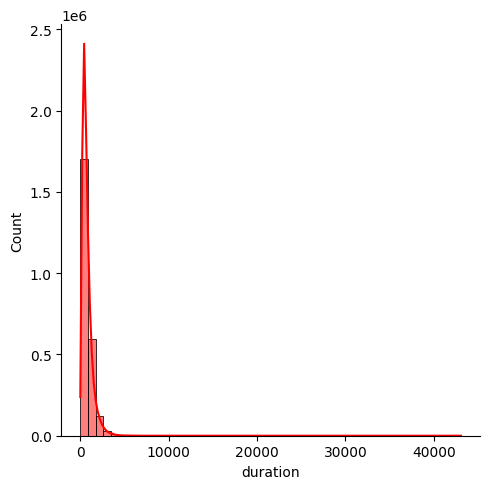

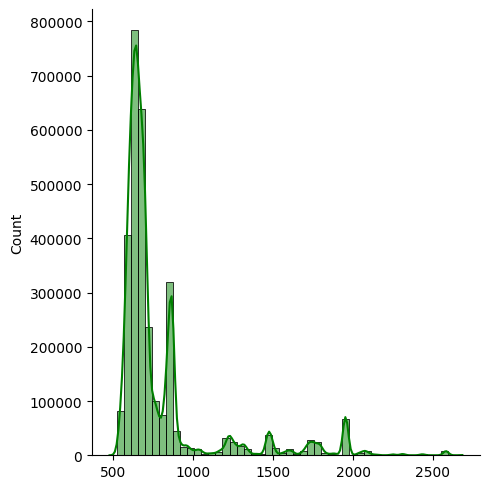

In [17]:
with mlflow.start_run():

    mlflow.set_tag("model", "linear_regression")

    mlflow.log_param("train_size", len(dftr))
    mlflow.log_param("test_size", len(dfts))

    alpha = 0.5

    mlflow.log_param("alpha", alpha)

    lr = Lasso(alpha=alpha)
    lr.fit(xtr, ytr)
    ypr = lr.predict(xts)

    print(mean_squared_error(yts, ypr, squared=False))

    mlflow.log_metric("rmse", mean_squared_error(yts, ypr, squared=False))

    sns.displot(dftr.duration, kde=True, bins=50, color="red")
    sns.displot(ypr, kde=True, bins=50, color='green')
    plt.show()

# trabaja con client

In [6]:
from mlflow.tracking import MlflowClient
from mlflow.store.artifact.runs_artifact_repo import RunsArtifactRepository

In [43]:
client = MlflowClient(tracking_uri=MLFLOW_TRACKING_URI)
print([(x.name, x._experiment_id) for x in client.search_experiments()])

[('duration_prediction', '1'), ('Default', '0')]


In [48]:
runs = client.search_runs(
    experiment_ids="1",
    filter_string="",
    run_view_type=mlflow.entities.ViewType.ACTIVE_ONLY,
    max_results=5,
    order_by=["metrics.rmse DESC"],
)

In [51]:
for run in runs:
    print(f"run id: {run.info.run_id}, rmse: {run.data.metrics['rmse']}")

run id: 6a3f6e720b2f4d8c93fd4fbb826a179f, rmse: 741.9610136847901
run id: 5f4ff5dae6a24484b0378bbbf4150371, rmse: 715.86450748692
run id: 9be3854a2f21451b8b6d18a417af9bdc, rmse: 654.3553990161859
run id: fa9bb0a8fb3e46eabafbc01dc6931daa, rmse: 649.0373151611307
run id: 0a300c819e3e49abab51f494fda75519, rmse: 644.0610432113446


In [8]:
xtr = dftr[categoricals + numericals].values
xts = dfts[categoricals + numericals].values
ytr, yts = dftr.duration.values, dfts.duration.values

xtr, xvl, ytr, yvl = train_test_split(xtr, ytr, test_size=0.2, random_state=42)

modelName = "xgboossRegressor"

with mlflow.start_run() as run:

    regressor = xgb.XGBRegressor(
        objective="reg:squarederror",
        n_estimators=100,
        learning_rate=0.1,
        max_depth=3,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        n_jobs=-1,
        eval_metric = mean_squared_error
    )

    regressor.fit(xtr, ytr, eval_set=[(xvl, yvl)])
    ypr = regressor.predict(xts)
    rmse = mean_squared_error(yts, ypr, squared=False)

    mlflow.xgboost.log_model(regressor, artifact_path="xgb_model")
    mlflow.xgboost.autolog()

# client = MlflowClient()
# client.create_registered_model(modelName)

# desc = "A new version of the model"
# runs_uri = "runs:/{}/xgb_model".format(run.info.run_id)
# model_src = RunsArtifactRepository.get_underlying_uri(runs_uri)
# mv = client.create_model_version(modelName, model_src, run.info.run_id, description=desc)
# print("Name: {}".format(mv.name))
# print("Version: {}".format(mv.version))
# print("Description: {}".format(mv.description))
# print("Status: {}".format(mv.status))
# print("Stage: {}".format(mv.current_stage))

[0]	validation_0-rmse:944.03878	validation_0-mean_squared_error:891209.31250
[1]	validation_0-rmse:871.14766	validation_0-mean_squared_error:758898.06250
[2]	validation_0-rmse:807.27062	validation_0-mean_squared_error:651685.93750
[3]	validation_0-rmse:751.52080	validation_0-mean_squared_error:564783.62500
[4]	validation_0-rmse:703.00227	validation_0-mean_squared_error:494212.21875
[5]	validation_0-rmse:661.00889	validation_0-mean_squared_error:436932.81250
[6]	validation_0-rmse:624.84935	validation_0-mean_squared_error:390436.71875
[7]	validation_0-rmse:593.97474	validation_0-mean_squared_error:352806.00000
[8]	validation_0-rmse:574.50416	validation_0-mean_squared_error:330055.03125
[9]	validation_0-rmse:551.25789	validation_0-mean_squared_error:303885.21875
[10]	validation_0-rmse:531.58470	validation_0-mean_squared_error:282582.28125
[11]	validation_0-rmse:520.47493	validation_0-mean_squared_error:270894.18750
[12]	validation_0-rmse:505.74586	validation_0-mean_squared_error:255778.89

2023/04/22 23:52:54 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/hilbert/.local/lib/python3.10/site-packages/xgboost/sklearn.py:761: UserWarning: eval_metric is not saved in Scikit-Learn meta."
/home/hilbert/.local/lib/python3.10/site-packages/xgboost/sklearn.py:761: UserWarning: eval_metric is not saved in Scikit-Learn meta.
  warnings.warn(


In [8]:
mv = client.transition_model_version_stage(modelName, mv.version, "staging")

def print_model_version_info(mv):
    print("Name: {}".format(mv.name))
    print("Version: {}".format(mv.version))
    print("Description: {}".format(mv.description))
    print("Stage: {}".format(mv.current_stage))

print_model_version_info(mv)

Name: xgboossRegressor
Version: 1
Description: A new version of the model
Stage: Staging
